In [1]:
import pandas as pd
import numpy as np
import importlib
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
import shap
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_roc_curve
from statistics import mean
from sklearn.ensemble import RandomForestClassifier
import re
import pickle

/home/parthb1024/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/parthb1024/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/home/parthb1024/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150

def clean_plot(leg=True, grid=None, font=None):
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    axis_color = 'lightgrey'
    ax.spines['bottom'].set_color(axis_color)
    ax.spines['left'].set_color(axis_color)
    ax.tick_params(axis='both', color=axis_color)
    
    if leg:
        ax.legend(frameon = False, loc='upper left', bbox_to_anchor=(1, 1))
        
    if grid is not None:
        plt.grid(color='lightgrey', axis = grid, linestyle='-', linewidth=.5)
        
    if font is not None:
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
            ax.get_xticklabels() + ax.get_yticklabels()):
            
            item.set_fontfamily(font['family'])
            item.set_color(font['color'])
            

In [3]:
from src.filter import Filter

[W031] Model 'en_core_web_sm' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.1). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/parthb1024/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


*Feature Extraction from Milk Papers*

In [7]:
mtrain_new = pd.read_csv("mBase_15Aug_abstract[chemical_gen].csv")
mtrain_new['food'] = 'human milk'
#mtrain_new = mtrain_new.rename({'Abstract':'abstract'})
#mtrain_new.rename(columns={'Abstract':'abstract'})
#mtrain_new.columns = ['abstract','Journal','PMID','Paper','WebPage','Year','food']
#mtrain_new['mesh_terms'] = '[]'
#mtrain_new['is_useful'] = '1'
mtrain_new = mtrain_new[mtrain_new['abstract'].notnull()]
mtrain_new = mtrain_new[mtrain_new['PMID'].notnull()]
mtrain_new

,PMID,abstract,journal,mesh_UIds,mesh_terms,paper,qual_UIds,qual_terms,webpage,year,is_useful,source,measmethod,food,chem_ent_ratio,chemicals,bigram_score,chem_term_count
0,11425797.0,"Specific human milk oligosaccharides, especial...",Glycobiology,"['D002236', 'D002240', 'D002851', 'D005260', '...","['Carbohydrate Conformation', 'Carbohydrate Se...",Fucosylated human milk oligosaccharides vary b...,"[None, None, None, None, 'Q000032', None, None...","[None, None, None, None, 'analysis', None, Non...",https://www.ncbi.nlm.nih.gov/pubmed/11425797,2001.0,1.0,Chaturvedi_01,['HPLC'],human milk,0.011364,['fucosyloligosaccharides'],0.2,1
1,17073150.0,The dependence of daily vitamin excretion with...,Bulletin of experimental biology and medicine,"['D000328', 'D001942', 'D002851', 'D005260', '...","['Adult', 'Breast Feeding', 'Chromatography, H...",Evaluation of the vitamin status in nursing wo...,"[None, None, None, None, None, 'Q000737', None...","[None, None, None, None, None, 'chemistry', No...",https://www.ncbi.nlm.nih.gov/pubmed/17073150,2006.0,1.0,Kodentsova_06,['HPLC'],human milk,0.423077,"['vitamins A', 'vitamins', 'vitamin B6', 'vita...",0.0,11
2,17941914.0,The sources and the impact of maternal bacteri...,Clinical and experimental allergy : journal of...,"['D039941', 'D001644', 'D005243', 'D005260', '...","['Bifidobacteriales Infections', 'Bifidobacter...",Maternal breast-milk and intestinal bifidobact...,"['Q000382', 'Q000502', 'Q000382', None, None, ...","['microbiology', 'physiology', 'microbiology',...",https://www.ncbi.nlm.nih.gov/pubmed/17941914,2008.0,0.0,Gronlund__07,[],human milk,0.000000,[],0.0,0
3,25221936.0,The benefits of human milk for preterm infants...,Journal of pediatric gastroenterology and nutr...,"['D000328', 'D053000', 'D000837', 'D002240', '...","['Adult', 'Analytic Sample Preparation Methods...",Effect of holder pasteurisation on human milk ...,"[None, None, None, None, None, None, 'Q000032'...","[None, None, None, None, None, None, 'analysis...",https://www.ncbi.nlm.nih.gov/pubmed/25221936,2015.0,1.0,Coscia_15,"['HPLC', 'Fluorometry']",human milk,0.000000,[],0.4,0
4,12741556.0,Sialyloligosaccharides and sialylglycoconjugat...,Journal of dairy science,"['D000818', 'D002417', 'D003126', 'D005260', '...","['Animals', 'Cattle', 'Colostrum', 'Female', '...",Concentrations of sialyloligosaccharides in bo...,"[None, 'Q000378', 'Q000737', None, 'Q000032', ...","[None, 'metabolism', 'chemistry', None, 'analy...",https://www.ncbi.nlm.nih.gov/pubmed/12741556,2003.0,0.0,Nakamura_03,[],human milk,0.105263,"['sialyloligosaccharides', 'sialyloligosacchar...",0.5,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,2998180.0,Vitamin D-deficiency rickets continues to be r...,American journal of diseases of children (1960),"['D015652', 'D000328', 'D044383', 'D001942', '...","['25-Hydroxyvitamin D 2', 'Adult', 'African Co...",Effect of race and diet on human-milk vitamin ...,"[None, None, None, None, 'Q000032', 'Q000032',...","[None, None, None, None, 'analysis', 'analysis...",https://www.ncbi.nlm.nih.gov/pubmed/2998180,1985.0,1.0,Specker_85,['compBinding'],human milk,0.306122,"['25-hydroxyvitamin D3', 'vitamin D2', 'Vitami...",0.6,15
225,18477059.0,Pasteurization is the thermal treatment usuall...,"Acta paediatrica (Oslo, Norway : 1992)","['D000328', 'D000975', 'D005260', 'D005978', '...","['Adult', 'Antioxidants', 'Female', 'Glutathio...",Antioxidant capacity of human milk: effect of ...,"[None, 'Q000032', None, 'Q000032', 'Q000032', ...","[None, 'analysis', None, 'analysis', 'analysis...",https://www.ncbi.nlm.nih.gov/pubmed/18477059,2008.0,1.0,Silvestre_08,"['Lawrence-Burk', 'HPLC', 'KPA-050']",human milk,0.000000,[],0.5,0
226,12225305.0,Lactogenesis II describes the onset of copious...,Acta obstetricia et gynecologica Scandinavica,"['D015415', 'D001942', 'D019343', 'D005260', '...","['Biomarkers', 'Breast Feeding', 'Citric Acid'...",Initiation of lactation in women after preterm...,"['

In [8]:
mmodel_data = Filter()
#oldm_model_data = Filter()
mmodel_data.build_features(input_data = mtrain_new,is_traindata = True)
#oldm_model_data.build_features(input_data = mtrain, is_traindata = True)

[W031] Model 'en_core_web_sm' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.1). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
0it [00:00, ?it/s]

Creating features...


229it [01:32,  2.49it/s]


In [11]:
mmodel_data.data['chem_ent_ratio'] = mtrain_new['chem_ent_ratio'].values
mmodel_data.data['chem_term_count'] = mtrain_new['chem_term_count'].values
mmodel_data.data['bigram_score'] = mtrain_new['bigram_score'].values
mmodel_data.data

,chromatography,class,food_term_count,gen_term_count,sci_term_count,spectrometry,spectrophotometry,chem_ent_ratio,bigram_score,chem_term_count
PMID,,,,,,,,,,
11425797,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.011364,0.2,1
17073150,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.423077,0.0,11
17941914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
25221936,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.4,0
12741556,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.105263,0.5,6
...,...,...,...,...,...,...,...,...,...,...
2998180,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.306122,0.6,15
18477059,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.5,0
12225305,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.0,1


In [12]:
def balanced_sample(df, train_frac=.7, val_frac=.2):
    val_s1 = df[df['class'] == 0].sample(frac=val_frac)
    val_s2 = df[df['class'] == 1].sample(frac=val_frac)
    
    val= pd.concat([val_s1, val_s2], axis=0, ignore_index=True, sort=False)
    
    df = df.drop(val_s1.index.tolist() + val_s2.index.tolist(), axis = 0)
    
    y = df.copy()['class']
    x = df.copy().drop('class', axis = 1)
    
    smote_x, smote_y = SMOTE().fit_sample(x, y)

    df = pd.DataFrame(smote_x, columns = x.columns)
    df['class'] = pd.Series(smote_y)
    
    train_s1 = df[df['class'] == 0].sample(frac=train_frac)
    train_s2 = df[df['class'] == 1].sample(frac=train_frac)
    
    test = df.drop(train_s1.index.tolist() + train_s2.index.tolist(), axis = 0)
    
    return pd.concat([train_s1, train_s2], axis=0, ignore_index=True, sort=False), test, val
    

*Generating Classifier from Garlic/Cocoa Data*

In [13]:
# gtrain = pd.read_csv("data/garlic_scoring.csv", encoding='latin1')[['PMID', 'abstract', 'paper', 'mesh_terms', 'qual_terms', 'is_useful']]
# gtrain['food'] = 'garlic'
# ctrain = pd.read_csv("data/cocoa_scoring.csv", encoding='latin1')[['PMID', 'abstract', 'paper', 'mesh_terms', 'qual_terms', 'is_useful']]
# ctrain['food'] = 'cocoa'

In [14]:
gtrain = pd.read_csv("garlic__abstract[chemical_gen].csv")
ctrain = pd.read_csv("cocoa__abstract[chemical_gen].csv")
gtrain

,PMID,abstract,paper,mesh_terms,qual_terms,is_useful,food,chem_ent_ratio,chemicals,bigram_score,chem_term_count
0,29693456,After gas chromatography and mass spectrometry...,Allium Sativum Methanolic Extract (garlic) Imp...,[],[],1.0,garlic,0.250000,"['alanine', 'Allium', 'bilirubin', '3- A. sati...",1,16
1,29653182,"Meju, a cooked and fermented soy bean based fo...",Detection of biogenic amines and microbial saf...,"['Biogenic Amines', 'Chromatography, High Pres...","['analysis', None, None, None, None, None, Non...",0.0,garlic,0.186813,"['tyramine', 'Ginkgo biloba', 'agmatine', 'Nel...",1,17
2,29542139,Allicin and soluble solid content (SSC) in gar...,Hyperspectral imaging for predicting the allic...,"['Algorithms', 'Calibration', 'Chemistry Techn...","[None, None, 'methods', 'chemistry', None, Non...",0.0,garlic,0.083333,"['Allicin', 'allicin']",1,2
3,29498844,We analyzed aged garlic extract (AGE) to under...,Isolation and Identification of Three Î³-Gluta...,"['Chromatography, High Pressure Liquid', 'Frui...","[None, 'chemistry', 'chemistry', 'chemistry', ...",0.0,garlic,0.229167,"['sulfur', 'GGS1PC', 'post-column', 'Î³-glutam...",1,11
4,29433241,Complexes of amylose (Am) with garlic bioactiv...,Physicochemical characteristics of complexes b...,[],[],2.0,garlic,0.071429,"['organosulfur', 'garlic bioactive components'...",1,4
...,...,...,...,...,...,...,...,...,...,...,...
410,552092,Oral administration of onion and garlic report...,Effects of onion (Allium cepa) extract on plat...,"['Adenosine Diphosphate', 'Animals', 'Arachido...","['pharmacology', None, 'blood', 'metabolism', ...",NaN,garlic,0.140351,"['arachidonic acid', 'ADP', 'Thromboxane', 'si...",1,8
411,719059,A method has been developed for the purificati...,[Alliinase: purification and chief physico-che...,"['Carbon-Sulfur Lyases', 'Chromatography, Ion ...","['isolation & purification', None, None, 'anal...",NaN,garlic,0.047619,"['alliin', 'pyridoxal phosphate']",1,2
412,902266,Hot-water extraction of defatted garlic-bulbs ...,Structure of the D-galactan isolated from garl...,"['Galactose', 'Garlic', 'Monosaccharides', 'Pl...","['analysis', 'analysis', 'analysis', 'analysis...",NaN,garlic,0.127660,"['formic acid', 'L-rhamnose', 'periodate', 'aq...",1,6
413,927476,The content of S-methylmethionine SMM in the e...,[S-Methylmethionine content in plant and anima...,"['Drug Stability', 'Food Analysis', 'Kinetics'...","[None, None, None, 'analogs & derivatives', 'a...",NaN,garlic,0.088889,"['strawberries', 'tomatoes', 'soil', 'raspberr...",1,4


In [15]:
gtrain = gtrain[gtrain['is_useful'].notnull()]
ctrain = ctrain[ctrain['is_useful'].notnull()]

gtrain['is_useful'] = gtrain['is_useful'].replace(2, 1, regex=True)
ctrain['is_useful'] = ctrain['is_useful'].replace(2, 1, regex=True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [16]:
gmodel_data = Filter()
cmodel_data = Filter()

gmodel_data.build_features(input_data = gtrain, is_traindata = True)
cmodel_data.build_features(input_data = ctrain, is_traindata = True)

[W031] Model 'en_core_web_sm' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.1). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
0it [00:00, ?it/s]

Creating features...


299it [02:04,  2.40it/s]
0it [00:00, ?it/s]

Creating features...


324it [02:22,  2.27it/s]


In [17]:
gmodel_data.data

,chromatography,class,food_term_count,gen_term_count,sci_term_count,spectrometry,spectrophotometry
PMID,,,,,,,
29693456,1.0,1.0,0.0,0.0,2.0,1.0,0.0
29653182,1.0,0.0,3.0,2.0,3.0,0.0,0.0
29542139,1.0,0.0,2.0,0.0,0.0,0.0,0.0
29498844,1.0,0.0,2.0,0.0,0.0,1.0,0.0
29433241,1.0,1.0,7.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...
1394291,1.0,0.0,1.0,0.0,2.0,0.0,0.0
2729582,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3798421,0.0,0.0,5.0,0.0,0.0,0.0,0.0


In [19]:
gmodel_data.data['chem_ent_ratio'] = gtrain['chem_ent_ratio'].values
gmodel_data.data['chem_term_count'] = gtrain['chem_term_count'].values
gmodel_data.data['bigram_score'] = gtrain['bigram_score'].values
cmodel_data.data['chem_ent_ratio'] = ctrain['chem_ent_ratio'].values
cmodel_data.data['chem_term_count'] = ctrain['chem_term_count'].values
cmodel_data.data['bigram_score'] = ctrain['bigram_score'].values
gmodel_data.data

,chromatography,class,food_term_count,gen_term_count,sci_term_count,spectrometry,spectrophotometry,chem_ent_ratio,chem_term_count,bigram_score
PMID,,,,,,,,,,
29693456,1.0,1.0,0.0,0.0,2.0,1.0,0.0,0.250000,16,1
29653182,1.0,0.0,3.0,2.0,3.0,0.0,0.0,0.186813,17,1
29542139,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.083333,2,1
29498844,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.229167,11,1
29433241,1.0,1.0,7.0,0.0,0.0,1.0,0.0,0.071429,4,1
...,...,...,...,...,...,...,...,...,...,...
1394291,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.246377,17,1
2729582,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,11,1
3798421,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.140351,8,1


In [20]:
# btrain = pd.read_excel('Basil_Papers_with_Predicted_Labels v1.0.xls')
# btrain['food'] = 'basil'
# #btrain = btrain[btrain['abstract'].notnull()]
# #btrain = btrain[btrain['PMID'].notnull()]
# for i in range(len(btrain)):
#     if btrain['is_useful'].loc[i] == 'x':
#         btrain['is_useful'].loc[i] = 0
#btrain

In [63]:
btrain = pd.read_csv("basil__abstract[chemical_gen].csv")
btrain

,Unnamed: 0,PMID,abstract,journal,mesh_UIds,mesh_terms,paper,qual_UIds,qual_terms,webpage,year,predicted_usefulness,is_useful,comments,food,chem_ent_ratio,chemicals,bigram_score,chem_term_count
0,10,29332819,The genus Ocimum (Labiatae) comprises 30 speci...,Talanta,"['D000080462', 'D000840', 'D002849', 'D002934'...","['Acyclic Monoterpenes', 'Anisoles', 'Chromato...",Chemometric analysis of NMR and GC datasets fo...,"[None, 'Q000032', 'Q000379', 'Q000032', 'Q0000...","[None, 'analysis', 'methods', 'analysis', 'ana...",https://www.ncbi.nlm.nih.gov/pubmed/29332819,2018,1,1,Essential oil,basil,0.119048,"['methyl chavicol', 'methyl cinnamate', 'eugen...",1,5
1,24,26797599,Solvent-free microwave extraction (SFME) and c...,"Molecules (Basel, Switzerland)","['D000890', 'D000975', 'D057168', 'D008401', '...","['Anti-Infective Agents', 'Antioxidants', 'Dis...",Comparative Study of Essential Oils Extracted ...,"['Q000737', 'Q000737', 'Q000379', None, None, ...","['chemistry', 'chemistry', 'methods', None, No...",https://www.ncbi.nlm.nih.gov/pubmed/26797599,2016,1,1,Essential oil,basil,0.104478,"['hydro-distillation', 'Ocimum basilicum L.) l...",1,7
2,26,26471526,In this study Ocimum basilicum L. (OB) and Oci...,Food chemistry,"['D002851', 'D005054', 'D066298', 'D018649', '...","['Chromatography, High Pressure Liquid', 'Euge...",Can Ocimum basilicum L. and Ocimum tenuiflorum...,"['Q000379', 'Q000737', None, 'Q000737', 'Q0007...","['methods', 'chemistry', None, 'chemistry', 'c...",https://www.ncbi.nlm.nih.gov/pubmed/26471526,2016,1,1,"Eugenol, phenolics",basil,0.234043,"['eugenol', 'OT', 'vanillin', 'vanillic acids'...",1,11
3,27,26470193,The fumigant activity of essential oil vapors ...,Journal of economic entomology,"['D000818', 'D005651', 'D007306', 'D007814', '...","['Animals', 'Fumigation', 'Insecticides', 'Lar...",Fumigant Toxicity of Essential Oils from Basil...,"[None, None, 'Q000032', None, None, 'Q000737',...","[None, None, 'analysis', None, None, 'chemistr...",https://www.ncbi.nlm.nih.gov/pubmed/26470193,2015,1,1,Essential oil,basil,0.111111,"['eugenol', 'spearmint oil carvone', 'spearmin...",1,9
4,30,25522548,The composition of hydrodistilled essential oi...,Natural product communications,"['D000080462', 'D000840', 'D000935', 'D003511'...","['Acyclic Monoterpenes', 'Anisoles', 'Antifung...",Compositional variability and antifungal poten...,"[None, 'Q000737', 'Q000737', 'Q000737', None, ...","[None, 'chemistry', 'chemistry', 'chemistry', ...",https://www.ncbi.nlm.nih.gov/pubmed/25522548,2015,1,1,Essential oil,basil,0.209677,"['Ocimum basilicum L.', 'methyl chavicol', 'mo...",1,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,87,11355006,Fatty acids are known as modulators of the vas...,Cellular and molecular biology (Noisy-le-Grand...,"['D015720', 'D002458', 'D002478', 'D016895', '...","[""5'-Nucleotidase"", 'Cell Fractionation', 'Cel...","Omegacoeur, a Mediterranean nutritional comple...","['Q000378', None, None, None, None, 'Q000166',...","['metabolism', None, None, None, None, 'cytolo...",https://www.ncbi.nlm.nih.gov/pubmed/11355006,2001,0,0,K-ATPase activity,basil,0.230769,"['lipids', 'Omegacoeur', 'lecithin', 'fatty ac...",1,18
89,89,10606575,"In this paper, three dissolution methods using...",Journal of agricultural and food chemistry,"['D000704', 'D002118', 'D002623', 'D003300', '...","['Analysis of Variance', 'Calcium', 'Chemistry...",Comparison of digestion methods for determinat...,"[None, 'Q000032', 'Q000379', 'Q000032', None, ...","[None, 'analysis', 'methods', 'analysis', None...",https://www.ncbi.nlm.nih.gov/pubmed/10606575,2000,0,1,Minerals,basil,0.344828,"['Cu', 'Fe', 'Ocimum basilicum', 'Allium', 'Mn...",1,20
90,90,9703700,A surway is presented on the authors' work in ...,Acta pharmaceutica Hungarica,"['D020843', 'D002849', 'D005419', 'D019684', '...","['Chamomile', 'Chromatography, Gas', 'Flavonoi...","[Phytochemical evaluation of essential oils, m...","[None, 'Q000379', 'Q

In [64]:
btrain['is_useful'][8]

0

In [65]:
bmodel_data = Filter()
bmodel_data.build_features(input_data = btrain, is_traindata = True)

[W031] Model 'en_core_web_sm' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.1). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
0it [00:00, ?it/s]

Creating features...


93it [00:38,  2.44it/s]


In [66]:
bmodel_data.data['chem_ent_ratio'] = btrain['chem_ent_ratio'].values
bmodel_data.data['chem_term_count'] = btrain['chem_term_count'].values
bmodel_data.data['bigram_score'] = btrain['bigram_score'].values

In [67]:
gdata = gmodel_data.data.copy()
cdata = cmodel_data.data.copy()
mdata = mmodel_data.data.copy()
bdata = bmodel_data.data.copy()
# gdata.to_pickle('misc_save/garlic_train_data.pkl')
# cdata.to_pickle('misc_save/cocoa_train_data.pkl')

# gdata = pd.read_pickle('misc_save/garlic_train_data.pkl')
# cdata = pd.read_pickle('misc_save/cocoa_train_data.pkl')
print(sum(gdata['class'].tolist() + cdata['class'].tolist()) / len(gdata['class'].tolist() + cdata['class'].tolist()))

gtrain, gtest, gval = balanced_sample(gdata)
ctrain, ctest, cval = balanced_sample(cdata)
mtrain, mtest, mval = balanced_sample(mdata)
btrain, btest, bval = balanced_sample(bdata)
#milk_train,milk_test,milk_val = balanced_sample(combined_df)
#milk_train, milk_val, milk_test = np.split(combined_df.sample(frac=1), [int(.6*len(combined_df)), int(.8*len(combined_df))])

train = pd.concat([gtrain, ctrain], axis=0, ignore_index=True, sort=False)
test = pd.concat([gtest, ctest], axis=0, ignore_index=True, sort=False)
#milk_train, milk_val, milk_test = mtrain, mval, mtest
val = pd.concat([gval, cval], axis=0, ignore_index=True, sort=False) # Does not incorporate SMOTE

0.27287319422150885


In [68]:
btest

,chromatography,food_term_count,gen_term_count,sci_term_count,spectrometry,spectrophotometry,chem_ent_ratio,chem_term_count,bigram_score,class
10,0.000000,2.000000,0.000000,0.000000,0.000000,0.0,0.046875,3,1,0.0
11,1.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.115385,6,1,1.0
12,1.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.075472,4,1,1.0
17,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.149254,10,1,1.0
22,0.000000,2.000000,0.000000,0.000000,1.000000,0.0,0.093023,8,1,0.0
23,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.250000,1,1,1.0
24,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0,1,0.0
27,0.000000,2.000000,0.000000,0.000000,0.000000,0.0,0.260000,13,1,0.0
30,1.000000,0.000000,1.000000,0.000000,1.000000,0.0,0.160920,14,1,1.0
35,0.000000,2.000000,0.000000,0.000000,0.000000,0.0,0.095238,6,1,1.0


In [69]:
y = train.copy()['class']
x = train.copy().drop('class', axis = 1)

# smote_x, smote_y = SMOTE().fit_sample(x, y)

x_val = val.copy().drop('class',axis=1)
y_val = val.copy()['class']

# x = pd.DataFrame(smote_x, columns = x.columns)
# y = pd.Series(smote_y)

# model = RandomForestClassifier(n_estimators = 10)
model = XGBClassifier(n_estimators=80)

model.fit(x, y)

y_test = test.copy()['class']

# Reorder columnt to align variables
x_test = test.copy().drop('class', axis = 1)

predictions = model.predict(x_test)

print('AUC:', roc_auc_score(y_test,predictions), '\n')

AUC: 0.7407407407407408 



In [70]:
cv_milk_data = pd.concat([mtrain,mtest,mval],ignore_index=True)
cv_milk_data_train = pd.concat([mtrain,mval],ignore_index=True)
cv_milk_data_test = mtest
cv_combined_data = pd.concat([mtrain,mtest,mval,ctrain,ctest,cval,gtrain,gtest,gval],ignore_index=True)
cv_combined_data

,chromatography,food_term_count,gen_term_count,sci_term_count,spectrometry,spectrophotometry,chem_ent_ratio,bigram_score,chem_term_count,class
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.032258,0.750000,1,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.074074,0.333333,4,0.0
2,0.0,0.0,0.0,0.0,0.510942,0.0,0.072464,0.484591,5,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.129032,0.235294,12,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.147727,0.000000,13,0.0
...,...,...,...,...,...,...,...,...,...,...
1095,1.0,2.0,2.0,0.0,0.000000,0.0,0.085106,1.000000,4,1.0
1096,0.0,4.0,1.0,5.0,1.000000,0.0,0.150000,1.000000,12,1.0
1097,0.0,1.0,0.0,0.0,0.000000,0.0,0.191489,1.000000,9,1.0
1098,0.0,6.0,0.0,2.0,0.000000,0.0,0.304348,1.000000,14,1.0


### Train on Garlic and Cocoa Dataset

In [71]:
def xgboost_model(x,y,n_splits = 15):
    cross_val_model = RandomForestClassifier(max_depth=10,random_state=0)
    kfold = StratifiedKFold(n_splits)
    auc = []
    for i,(train,test) in enumerate(kfold.split(x,y)):
        #print(train)
        cross_val_model.fit(x.loc[train],y.loc[train])
        viz = plot_roc_curve(cross_val_model, x.loc[test], y.loc[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1)
        auc.append(viz.roc_auc)
    return cross_val_model,mean(auc)
    

# model_cross_val = XGBClassifier()
# kfold = StratifiedKFold(n_splits=15)
# auc = []
# for i,(train,test) in enumerate(kfold.split(x,y)):
#     #print(train)
#     model_cross_val.fit(x.loc[train],y.loc[train])
#     viz = plot_roc_curve(model_cross_val, x.loc[test], y.loc[test],
#                          name='ROC fold {}'.format(i),
#                          alpha=0.3, lw=1)
#     auc.append(viz.roc_auc)

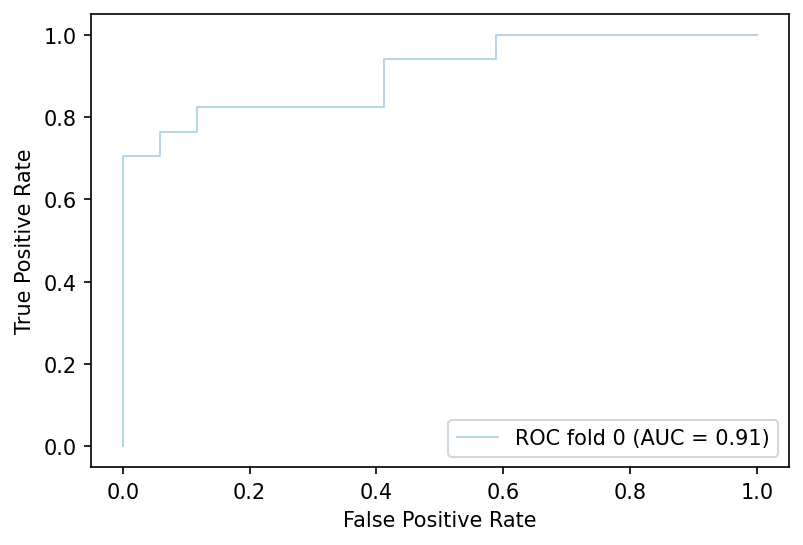

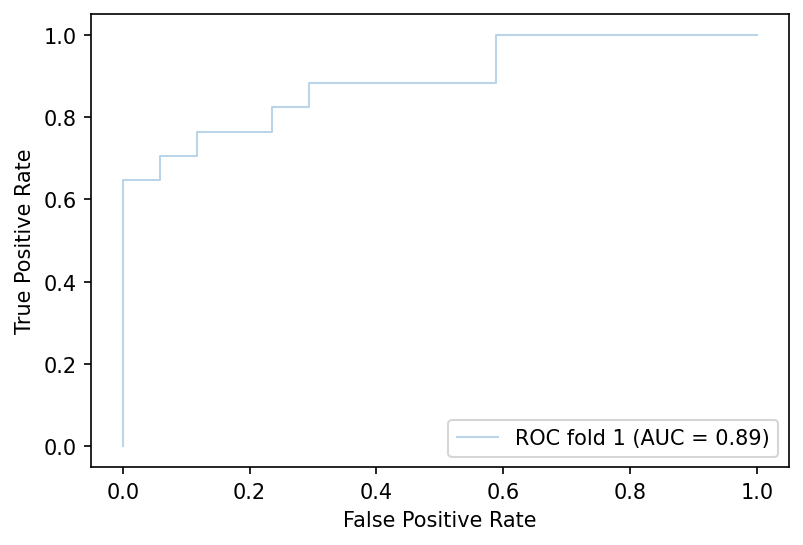

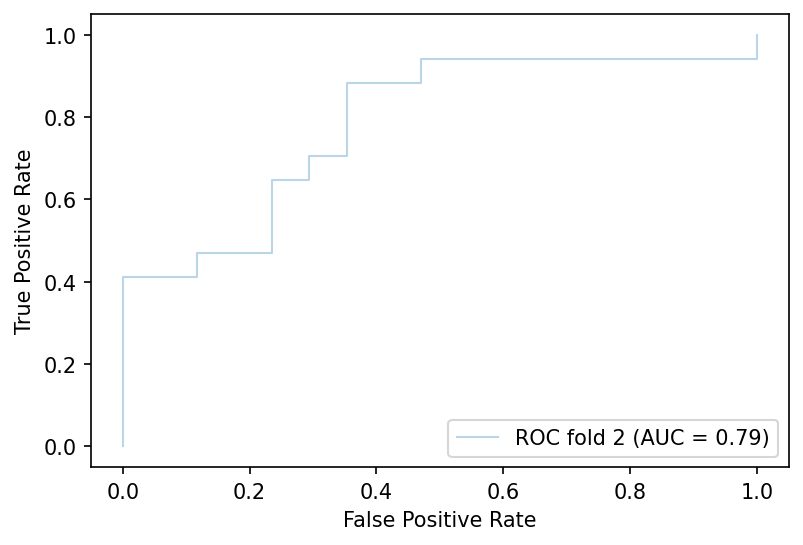

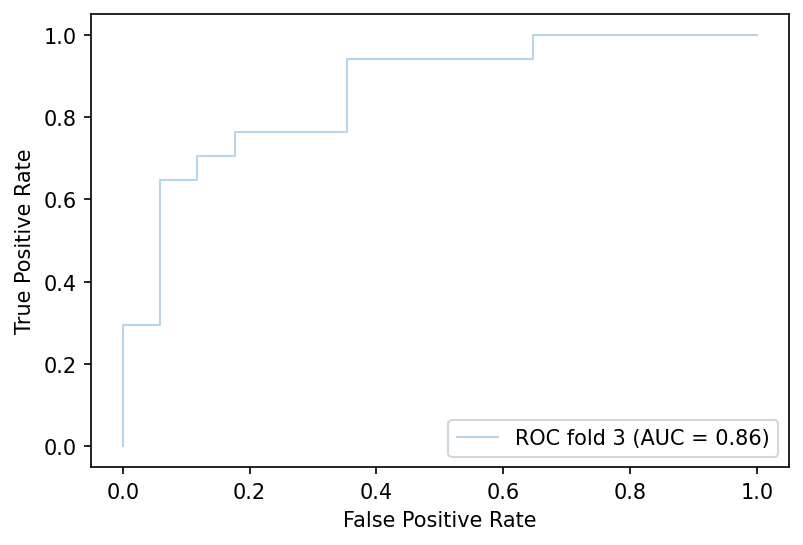

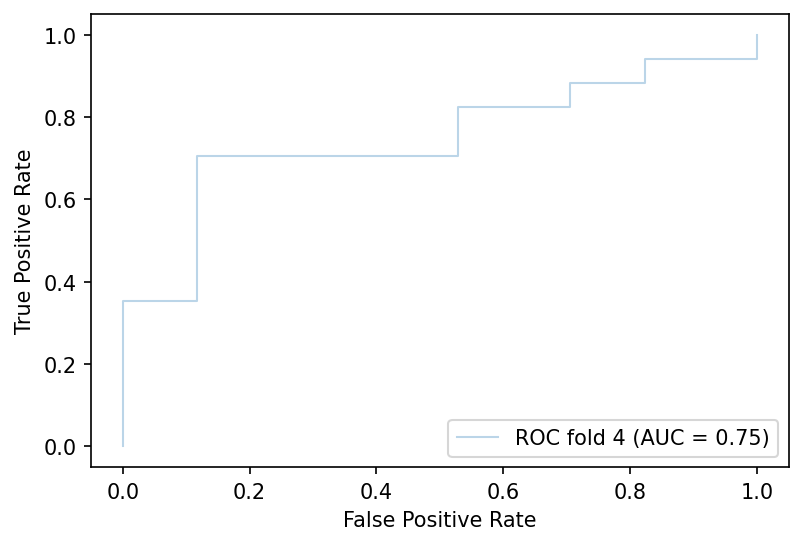

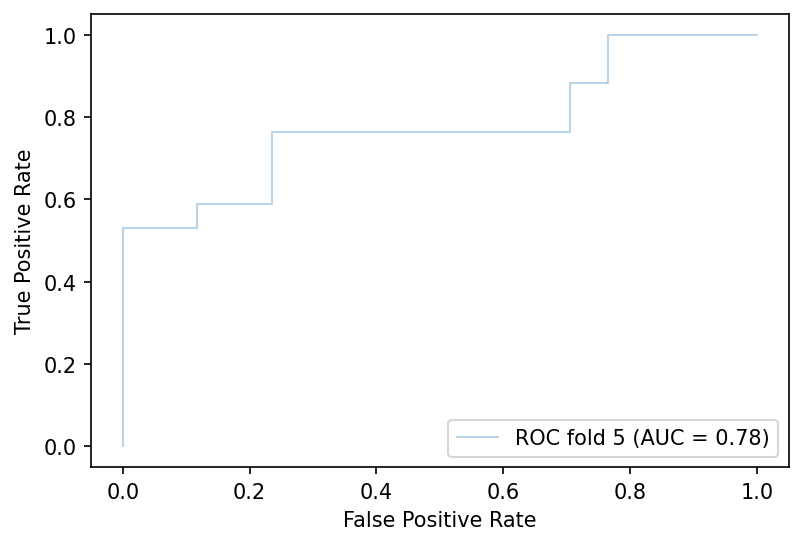

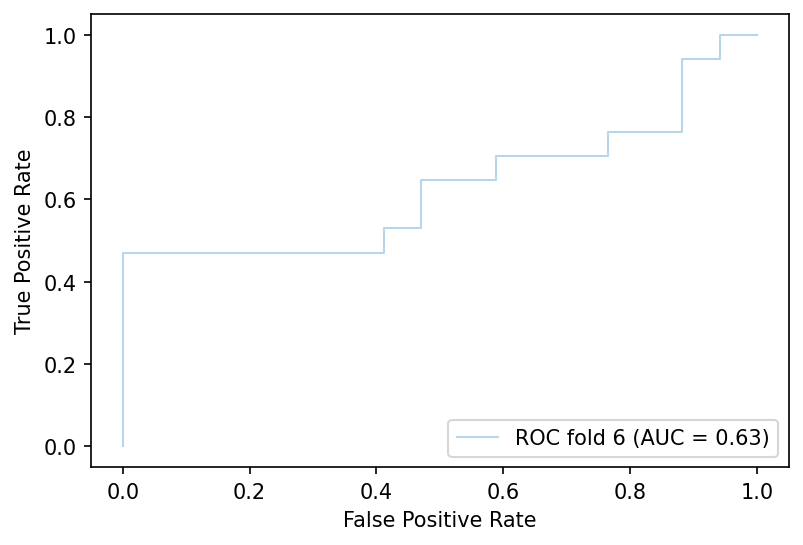

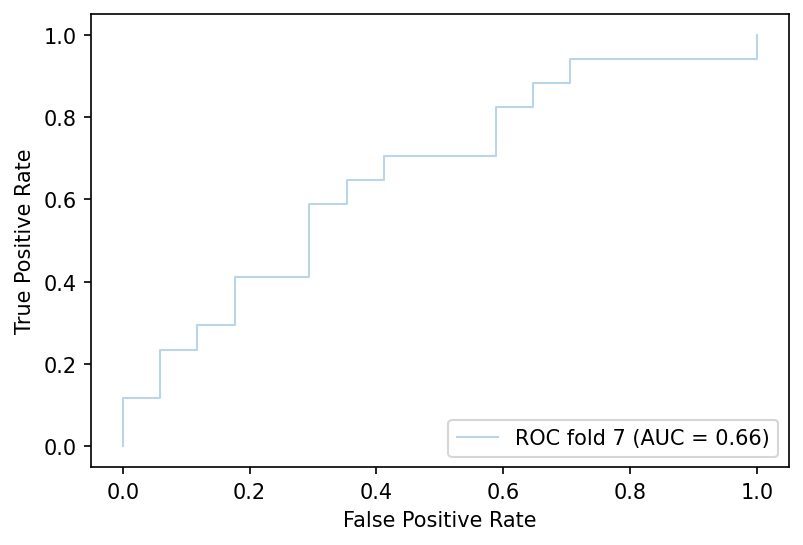

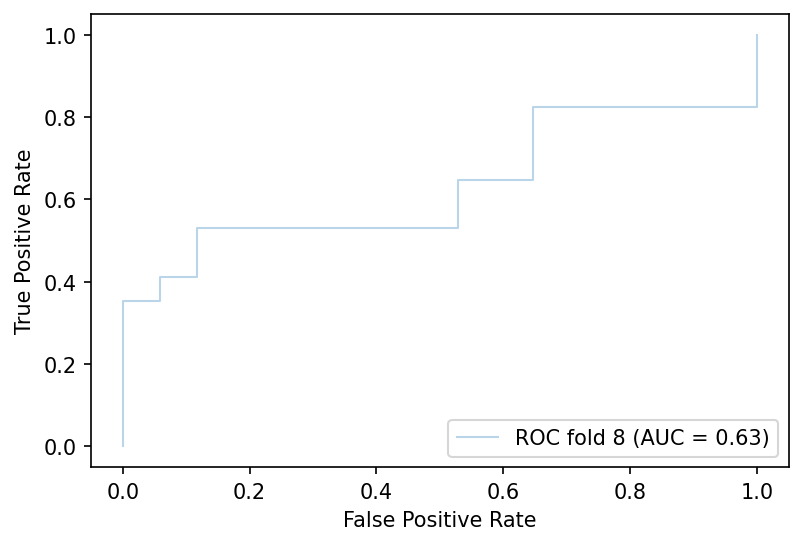

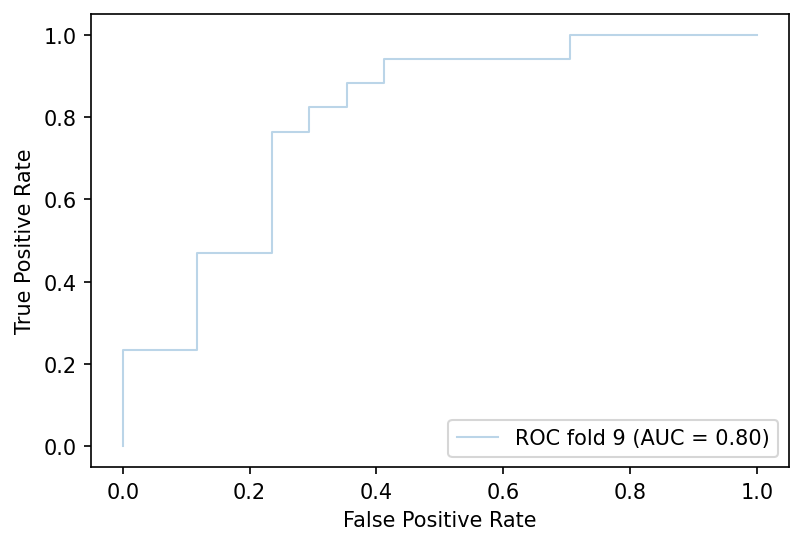

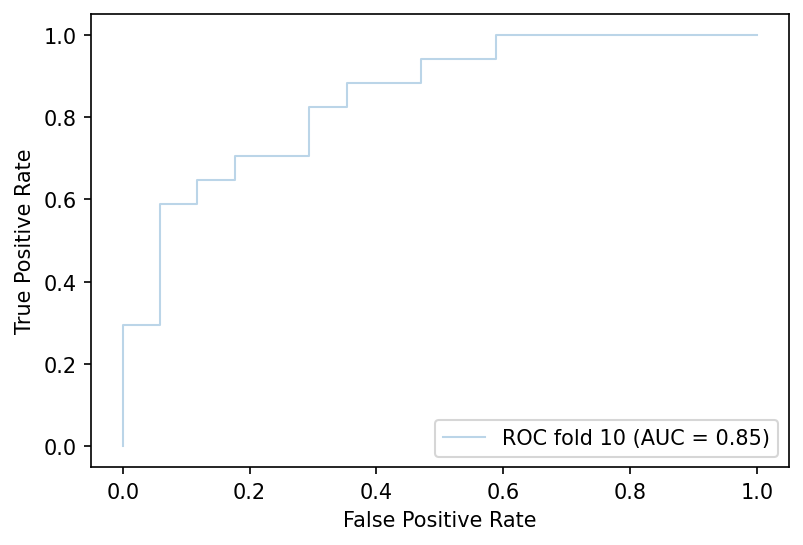

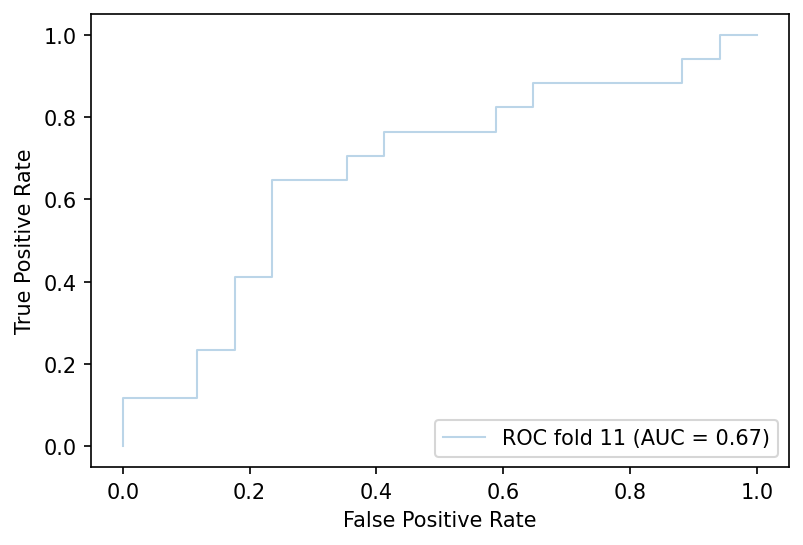

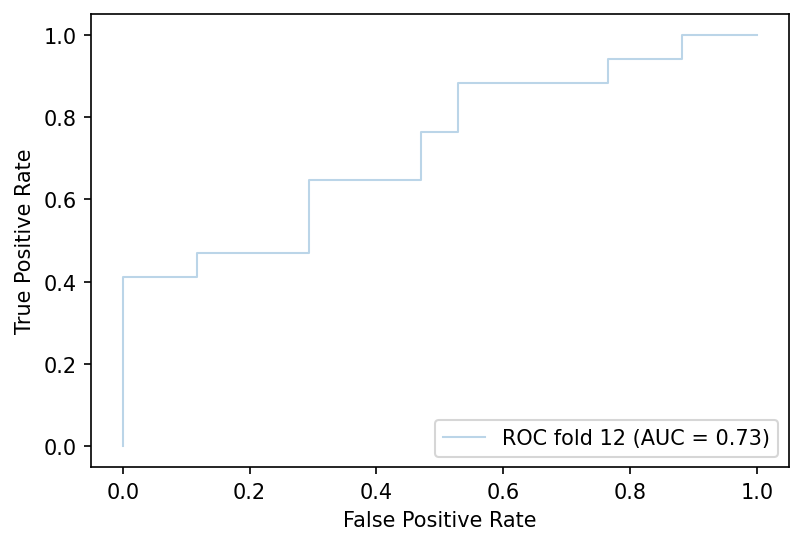

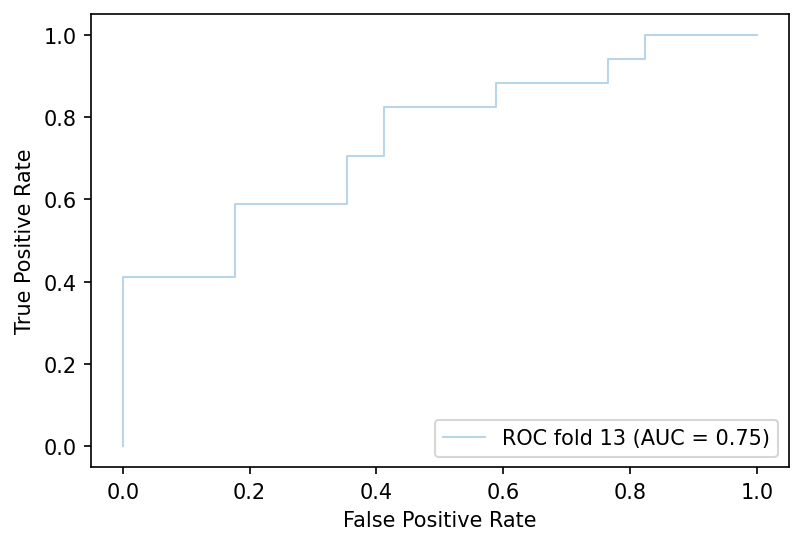

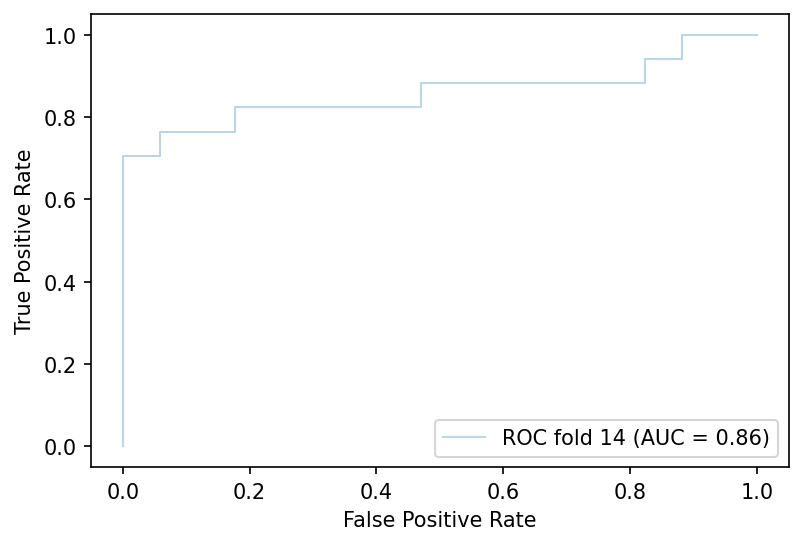

In [72]:
model_cross_val,auc = xgboost_model(x,y)

In [73]:
auc

0.7697808535178777

In [74]:
pd.DataFrame({'feature' : x.columns, 'importance' : model_cross_val.feature_importances_}).sort_values('importance', ascending=False)

,feature,importance
6,chem_ent_ratio,0.275625
7,chem_term_count,0.182619
1,food_term_count,0.168511
0,chromatography,0.139140
4,spectrometry,0.107974
2,gen_term_count,0.072699
3,sci_term_count,0.052116
5,spectrophotometry,0.001316
8,bigram_score,0.000000


In [75]:
pd.DataFrame({'feature' : x.columns, 'importance' : model.feature_importances_}).sort_values('importance', ascending=False)

,feature,importance
0,chromatography,0.278572
4,spectrometry,0.228411
2,gen_term_count,0.123057
1,food_term_count,0.104040
7,chem_term_count,0.089711
6,chem_ent_ratio,0.089037
3,sci_term_count,0.087172
5,spectrophotometry,0.000000
8,bigram_score,0.000000


In [76]:
xgb_predict = model_cross_val.predict(x_test)
roc_auc_score(y_test,xgb_predict)

0.7268518518518517

In [77]:
target = ['class 0', 'class 1']
classification_report(y_test,xgb_predict,target_names=target)

'              precision    recall  f1-score   support\n\n     class 0       0.72      0.73      0.73       108\n     class 1       0.73      0.72      0.73       108\n\n    accuracy                           0.73       216\n   macro avg       0.73      0.73      0.73       216\nweighted avg       0.73      0.73      0.73       216\n'

### Testing on  Milk Dataset

In [78]:
my = cv_milk_data.copy()['class']
mx = cv_milk_data.copy().drop('class',axis = 1)
mx

,chromatography,food_term_count,gen_term_count,sci_term_count,spectrometry,spectrophotometry,chem_ent_ratio,bigram_score,chem_term_count
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.032258,0.750000,1
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.074074,0.333333,4
2,0.0,0.0,0.0,0.0,0.510942,0.0,0.072464,0.484591,5
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.129032,0.235294,12
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.147727,0.000000,13
...,...,...,...,...,...,...,...,...,...
245,0.0,0.0,0.0,0.0,0.000000,0.0,0.106383,0.000000,10
246,0.0,0.0,0.0,0.0,0.000000,0.0,0.307692,0.000000,4
247,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0
248,0.0,0.0,0.0,0.0,0.000000,0.0,0.192771,0.222222,16


In [79]:
milk_predict = model_cross_val.predict(mx)
classification_report(my,milk_predict)

'              precision    recall  f1-score   support\n\n         0.0       0.49      1.00      0.66       122\n         1.0       1.00      0.01      0.02       128\n\n    accuracy                           0.49       250\n   macro avg       0.74      0.50      0.34       250\nweighted avg       0.75      0.49      0.33       250\n'

In [80]:
roc_auc_score(my,milk_predict)

0.50390625

In [81]:
confusion_matrix(my,milk_predict)

array([[122,   0],
       [127,   1]])

### Testing on Basil Dataset

In [82]:
by = bdata.copy()['class']
bx = bdata.copy().drop('class',axis = 1)
bx

,chromatography,food_term_count,gen_term_count,sci_term_count,spectrometry,spectrophotometry,chem_ent_ratio,chem_term_count,bigram_score
PMID,,,,,,,,,
29332819,0.0,0.0,1.0,0.0,0.0,0.0,0.119048,5,1
26797599,0.0,0.0,1.0,0.0,0.0,0.0,0.104478,7,1
26471526,0.0,0.0,1.0,0.0,0.0,0.0,0.234043,11,1
26470193,1.0,7.0,0.0,1.0,1.0,0.0,0.111111,9,1
25522548,1.0,0.0,1.0,0.0,1.0,0.0,0.209677,13,1
...,...,...,...,...,...,...,...,...,...
11355006,1.0,1.0,0.0,0.0,0.0,0.0,0.230769,18,1
10606575,0.0,1.0,0.0,5.0,1.0,0.0,0.344828,20,1
9703700,0.0,4.0,0.0,0.0,0.0,0.0,0.147727,13,1


In [83]:
basil_predict = model_cross_val.predict(bx)
classification_report(by,basil_predict)

'              precision    recall  f1-score   support\n\n         0.0       0.39      0.81      0.52        36\n         1.0       0.61      0.19      0.29        57\n\n    accuracy                           0.43        93\n   macro avg       0.50      0.50      0.41        93\nweighted avg       0.52      0.43      0.38        93\n'

In [84]:
roc_auc_score(by,basil_predict)

0.4992690058479532

In [85]:
confusion_matrix(by,basil_predict)

array([[29,  7],
       [46, 11]])

### Train on Milk Dataset

In [86]:
xmilk_train = cv_milk_data_train.copy().drop('class',axis=1)
ymilk_train = cv_milk_data_train.copy()['class']
xmilk_test = mtest.copy().drop('class',axis=1)
ymilk_test = mtest.copy()['class']

In [87]:
xmilk_train

,chromatography,food_term_count,gen_term_count,sci_term_count,spectrometry,spectrophotometry,chem_ent_ratio,bigram_score,chem_term_count
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.032258,0.750000,1
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.074074,0.333333,4
2,0.0,0.0,0.0,0.0,0.510942,0.0,0.072464,0.484591,5
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.129032,0.235294,12
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.147727,0.000000,13
...,...,...,...,...,...,...,...,...,...
183,0.0,0.0,0.0,0.0,0.000000,0.0,0.106383,0.000000,10
184,0.0,0.0,0.0,0.0,0.000000,0.0,0.307692,0.000000,4
185,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0
186,0.0,0.0,0.0,0.0,0.000000,0.0,0.192771,0.222222,16


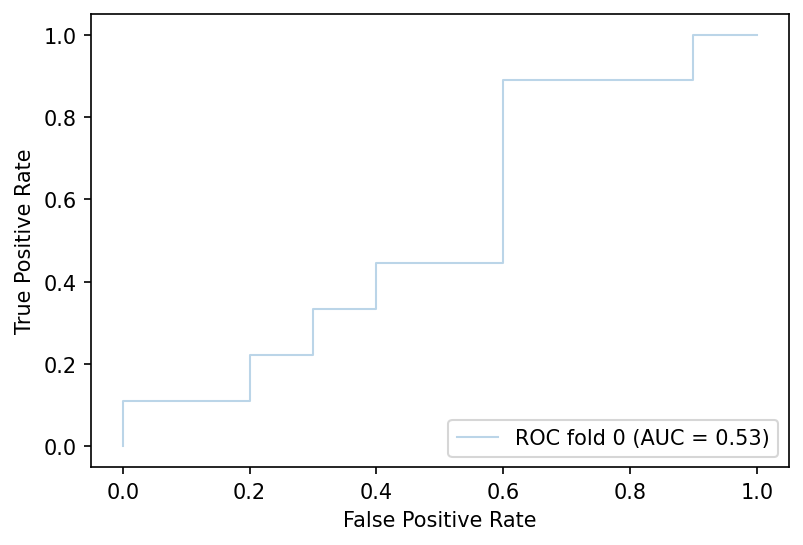

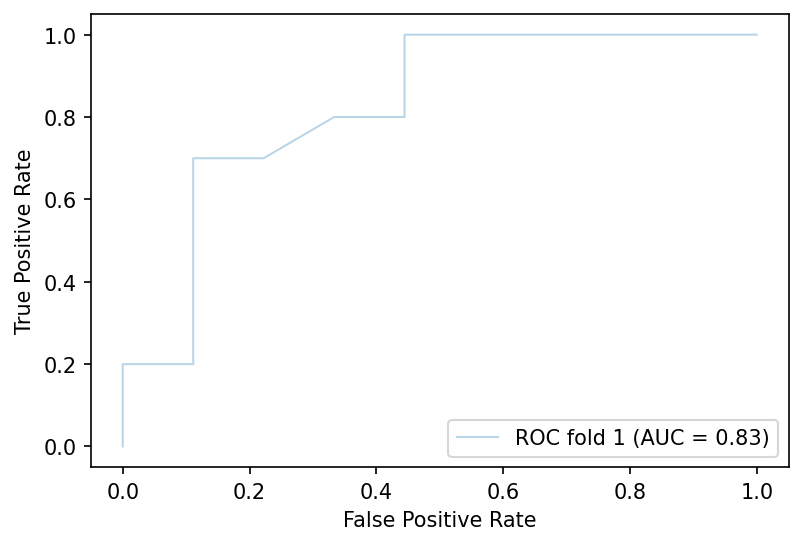

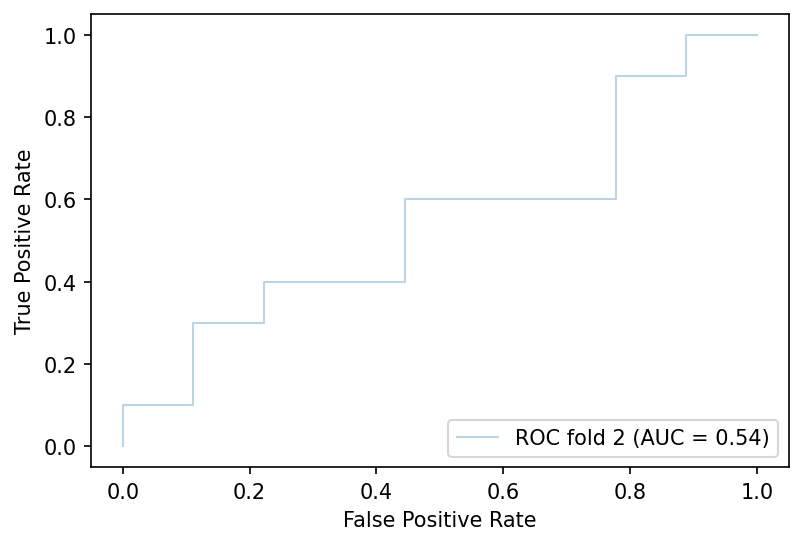

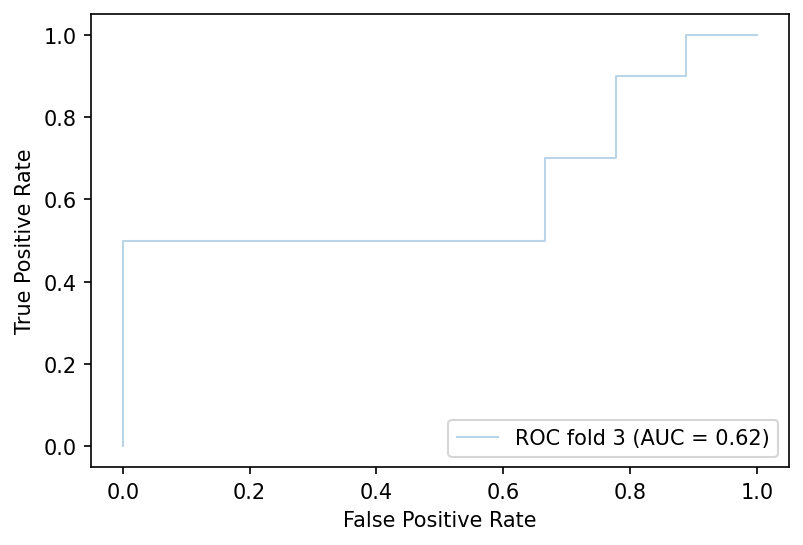

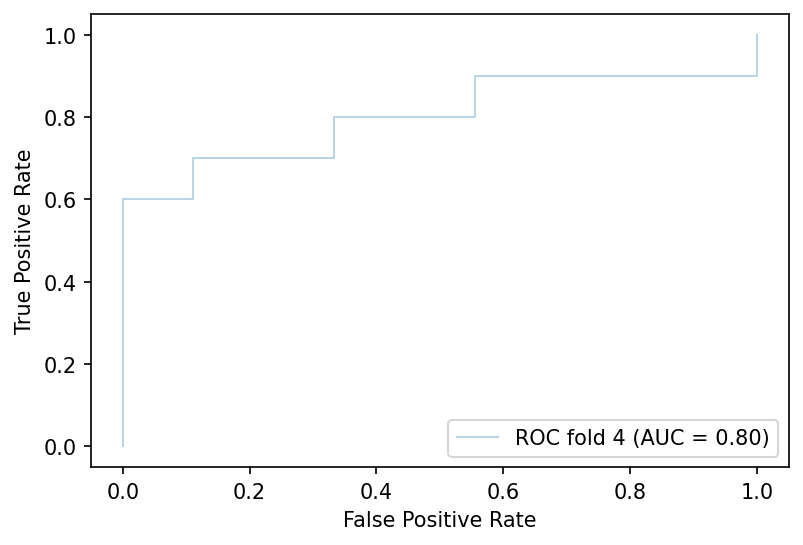

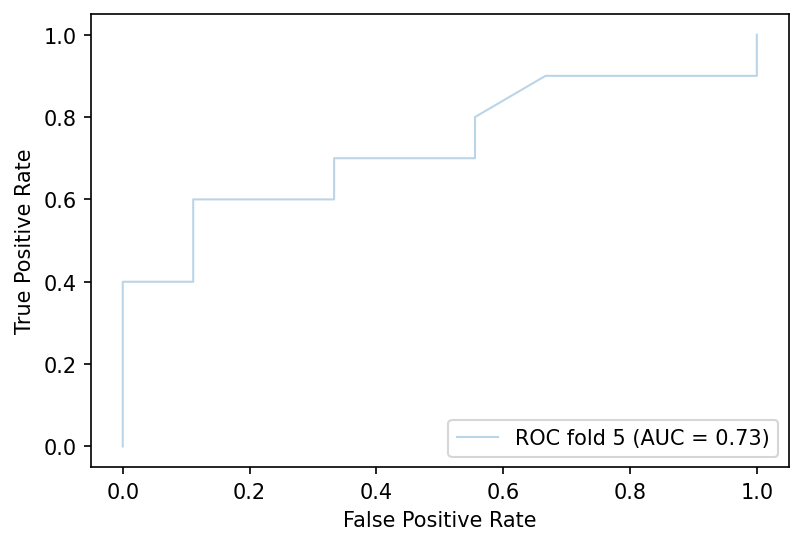

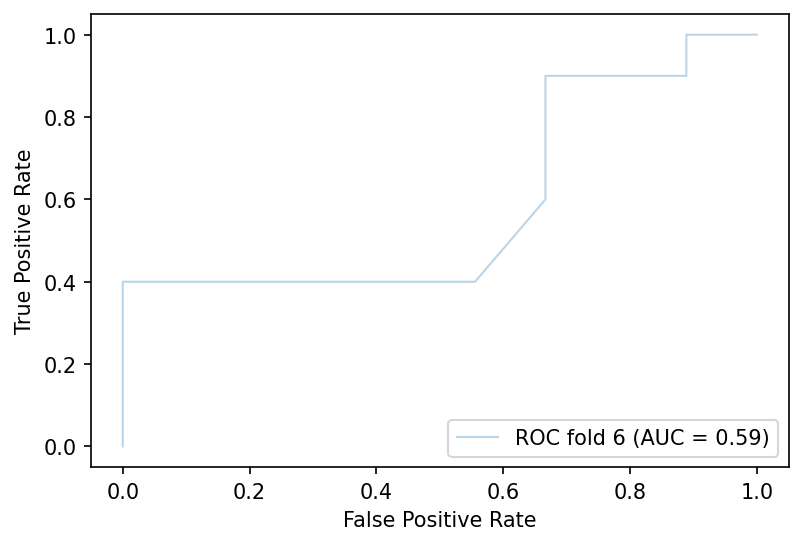

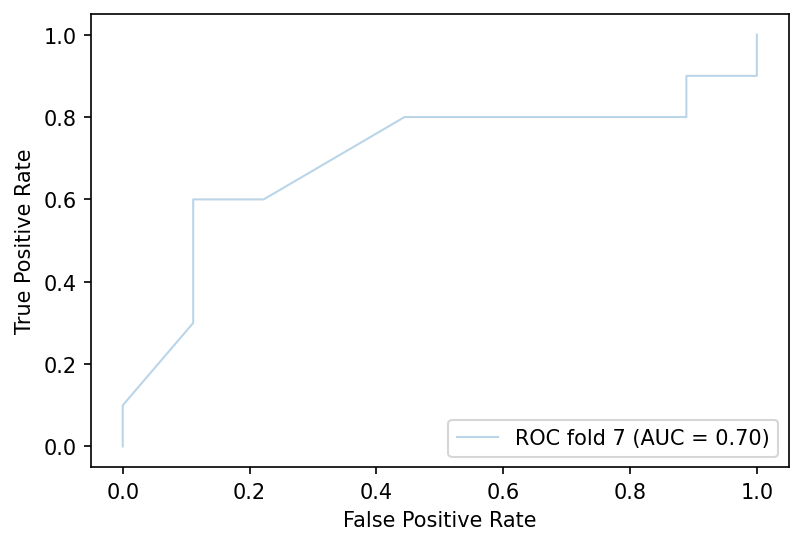

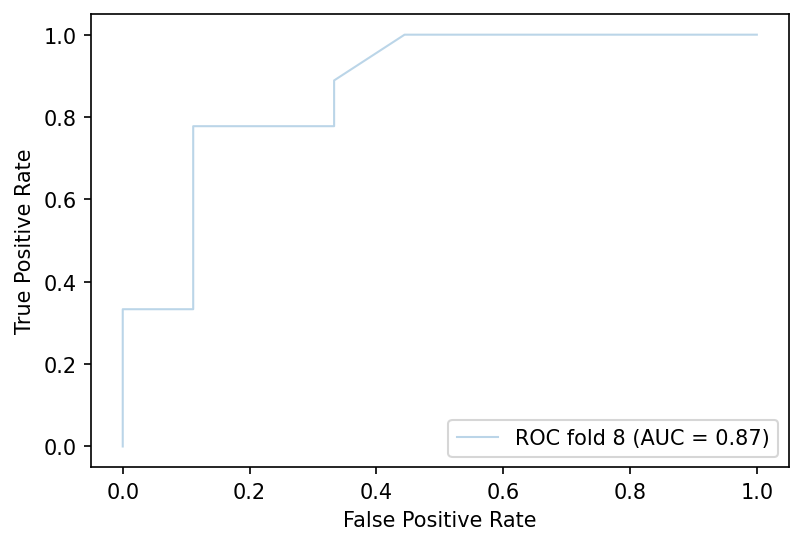

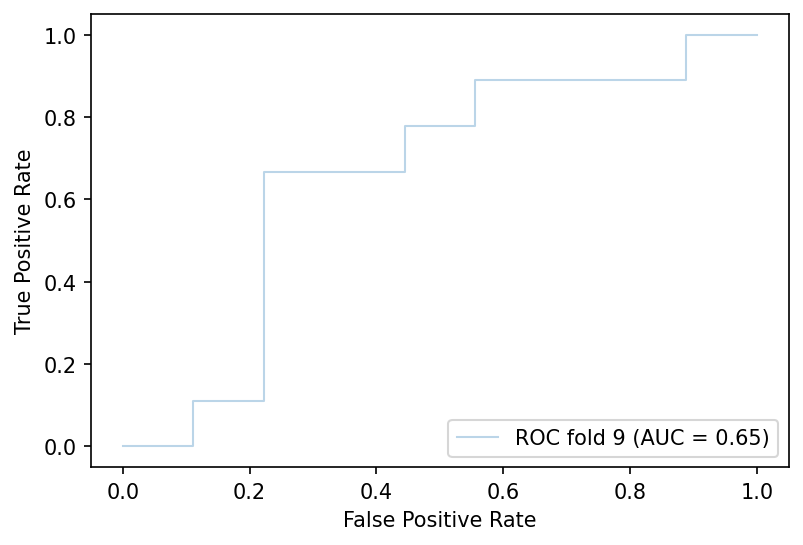

In [88]:
milk_model,milk_auc = xgboost_model(xmilk_train,ymilk_train,n_splits = 10)

In [89]:
milk_auc

0.6869135802469136

In [90]:
pd.DataFrame({'feature' : xmilk_train.columns, 'importance' : milk_model.feature_importances_}).sort_values('importance', ascending=False)

,feature,importance
6,chem_ent_ratio,0.344742
7,bigram_score,0.247191
8,chem_term_count,0.197816
1,food_term_count,0.083936
2,gen_term_count,0.051877
0,chromatography,0.043194
4,spectrometry,0.020115
3,sci_term_count,0.008521
5,spectrophotometry,0.002608


In [91]:
milk_model_name = "milk_model.pkl"
with open(milk_model_name, 'wb') as file:
    pickle.dump(milk_model, file)
    
'''
To load a saved model

with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

'''


"\nTo load a saved model\n\nwith open(pkl_filename, 'rb') as file:\n    pickle_model = pickle.load(file)\n\n"

In [92]:
xgb_predict_milk = milk_model.predict(xmilk_test)
roc_auc_score(ymilk_test,xgb_predict_milk)

0.5967741935483871

In [93]:
target = ['class 0', 'class 1']
classification_report(ymilk_test,xgb_predict_milk,target_names=target)

'              precision    recall  f1-score   support\n\n     class 0       0.59      0.61      0.60        31\n     class 1       0.60      0.58      0.59        31\n\n    accuracy                           0.60        62\n   macro avg       0.60      0.60      0.60        62\nweighted avg       0.60      0.60      0.60        62\n'

## Combined Model

In [94]:
xcombined = cv_combined_data.copy().drop('class',axis=1)
ycombined = cv_combined_data.copy()['class']
xcombined

,chromatography,food_term_count,gen_term_count,sci_term_count,spectrometry,spectrophotometry,chem_ent_ratio,bigram_score,chem_term_count
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.032258,0.750000,1
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.074074,0.333333,4
2,0.0,0.0,0.0,0.0,0.510942,0.0,0.072464,0.484591,5
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.129032,0.235294,12
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.147727,0.000000,13
...,...,...,...,...,...,...,...,...,...
1095,1.0,2.0,2.0,0.0,0.000000,0.0,0.085106,1.000000,4
1096,0.0,4.0,1.0,5.0,1.000000,0.0,0.150000,1.000000,12
1097,0.0,1.0,0.0,0.0,0.000000,0.0,0.191489,1.000000,9
1098,0.0,6.0,0.0,2.0,0.000000,0.0,0.304348,1.000000,14


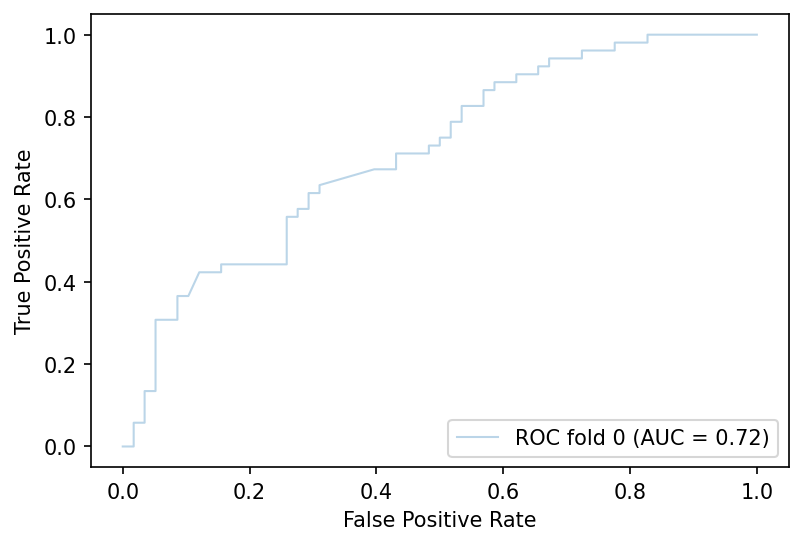

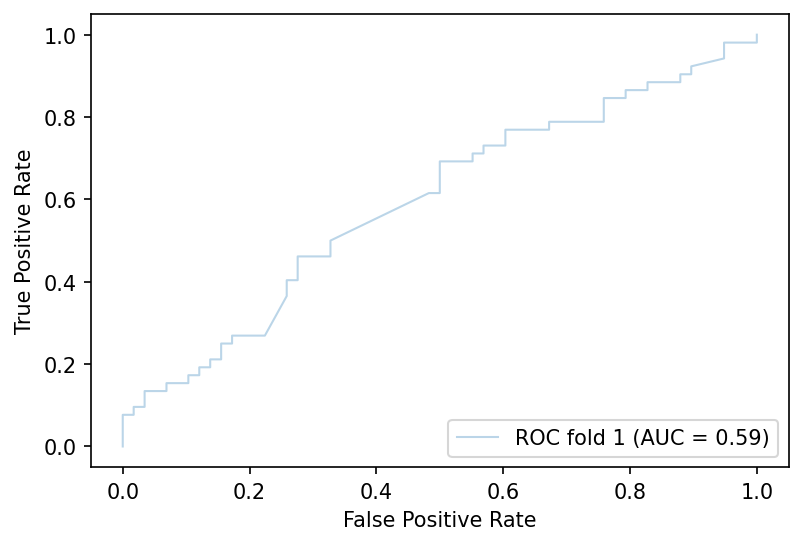

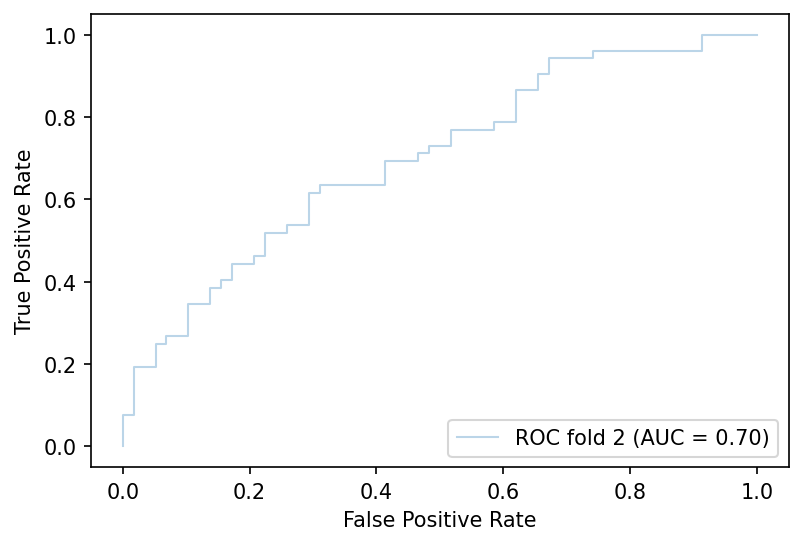

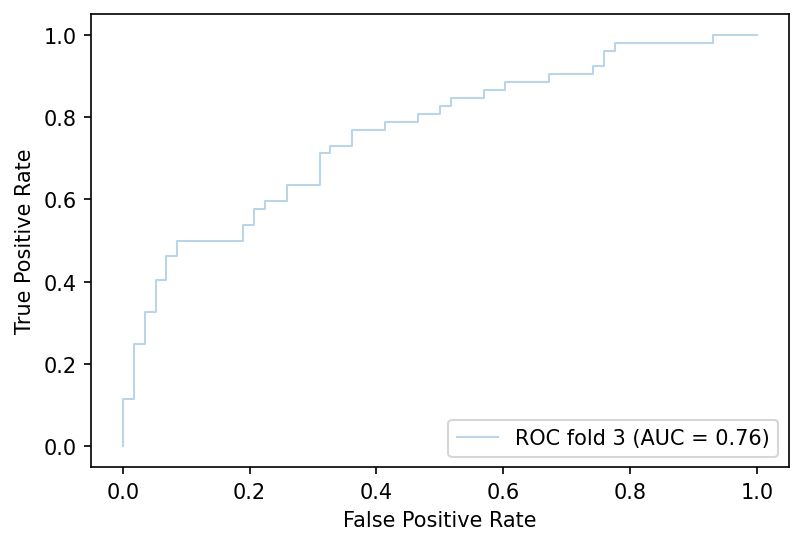

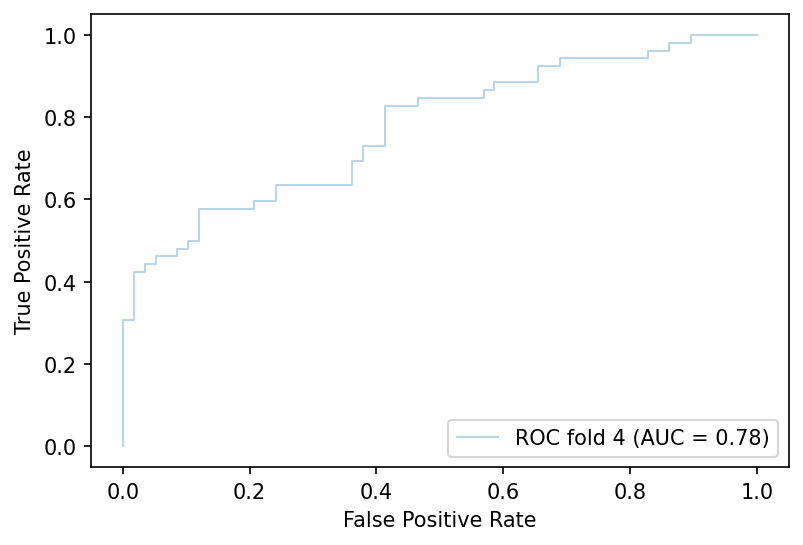

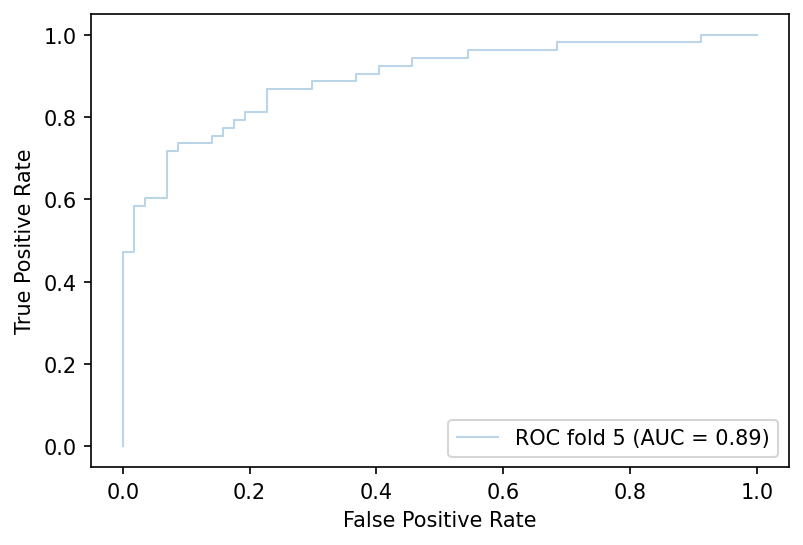

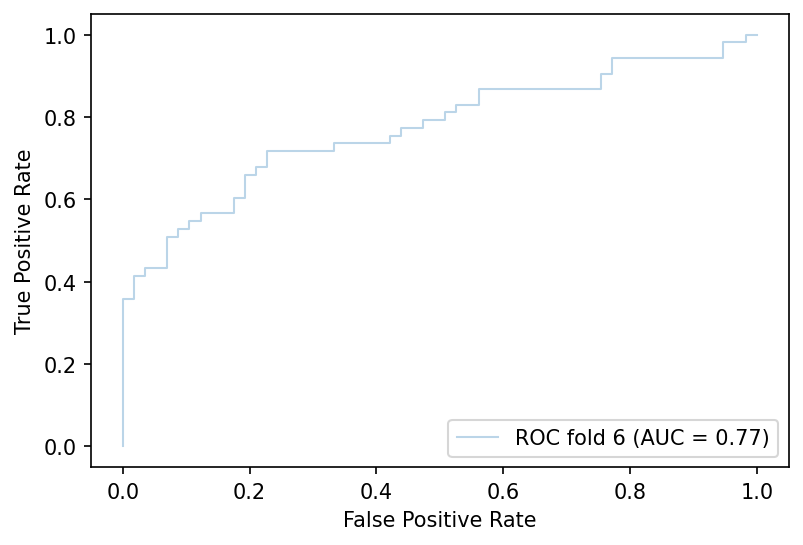

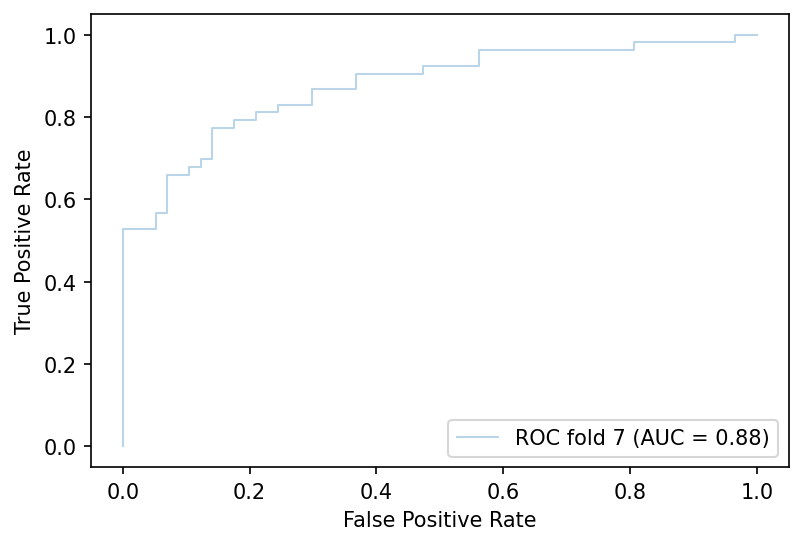

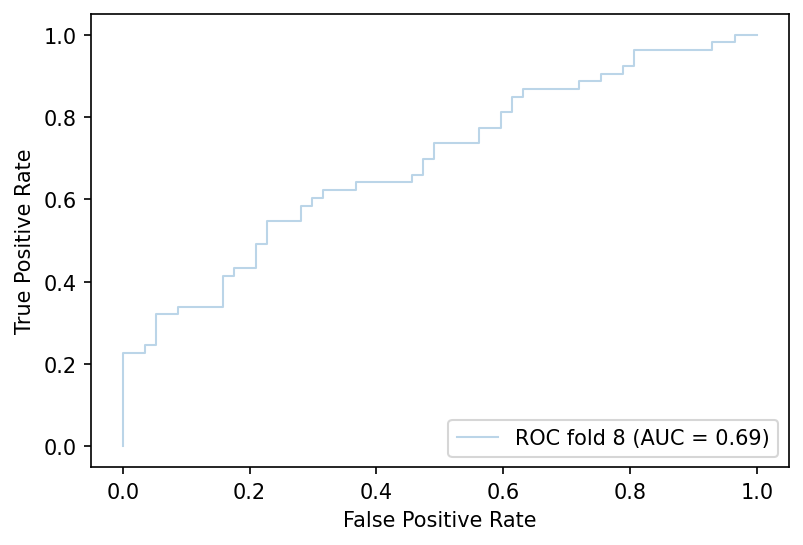

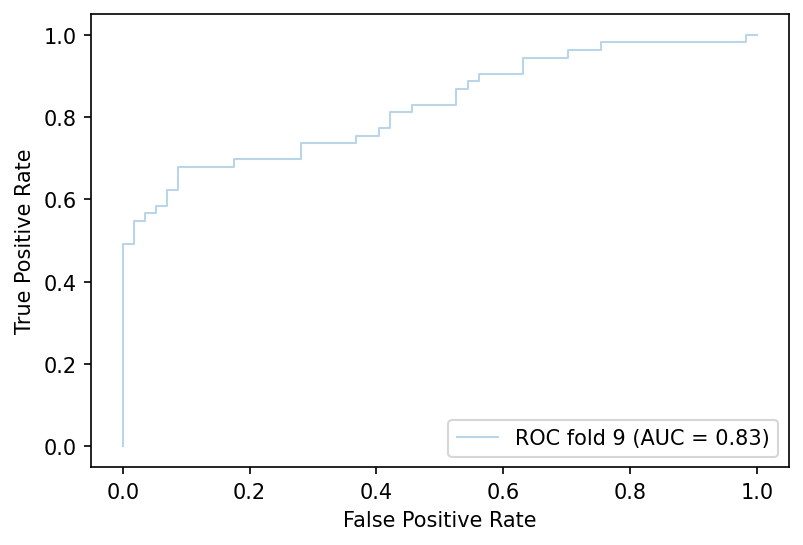

In [95]:
combined_model,combined_auc = xgboost_model(xcombined,ycombined,n_splits = 10)

In [96]:
combined_auc

0.7605669903952614

In [97]:
pd.DataFrame({'feature' : xcombined.columns, 'importance' : combined_model.feature_importances_}).sort_values('importance', ascending=False)

,feature,importance
6,chem_ent_ratio,0.282692
8,chem_term_count,0.167109
1,food_term_count,0.151786
0,chromatography,0.109661
2,gen_term_count,0.093955
4,spectrometry,0.084637
7,bigram_score,0.068245
3,sci_term_count,0.040525
5,spectrophotometry,0.001388


In [98]:
btest

,chromatography,food_term_count,gen_term_count,sci_term_count,spectrometry,spectrophotometry,chem_ent_ratio,chem_term_count,bigram_score,class
10,0.000000,2.000000,0.000000,0.000000,0.000000,0.0,0.046875,3,1,0.0
11,1.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.115385,6,1,1.0
12,1.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.075472,4,1,1.0
17,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.149254,10,1,1.0
22,0.000000,2.000000,0.000000,0.000000,1.000000,0.0,0.093023,8,1,0.0
23,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.250000,1,1,1.0
24,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0,1,0.0
27,0.000000,2.000000,0.000000,0.000000,0.000000,0.0,0.260000,13,1,0.0
30,1.000000,0.000000,1.000000,0.000000,1.000000,0.0,0.160920,14,1,1.0
35,0.000000,2.000000,0.000000,0.000000,0.000000,0.0,0.095238,6,1,1.0


In [99]:
combined_model_name = "combined_model.pkl"
with open(milk_model_name, 'wb') as file:
    pickle.dump(combined_model, file)

In [100]:
xbasil_test = btest.copy().drop('class',axis=1)
ybasil_test = btest.copy()['class']

In [101]:
xgb_predict_basil = combined_model.predict(xbasil_test)
roc_auc_score(ybasil_test,xgb_predict_basil)

0.2857142857142857

### Train on Basil Dataset

In [82]:
xbasil_train = btrain.copy().drop('class',axis=1)
ybasil_train = btrain.copy()['class']

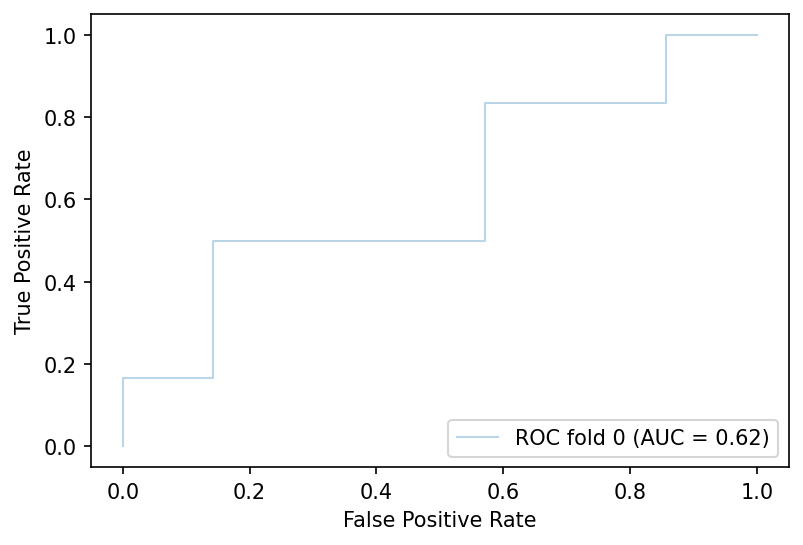

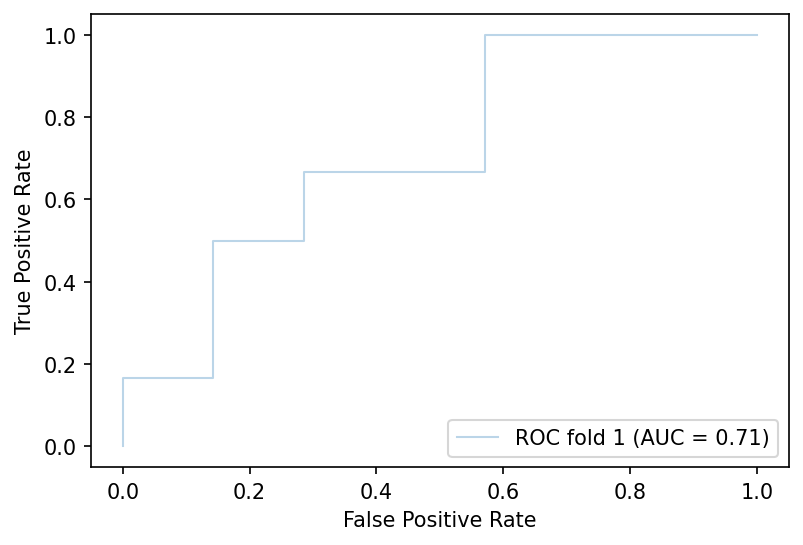

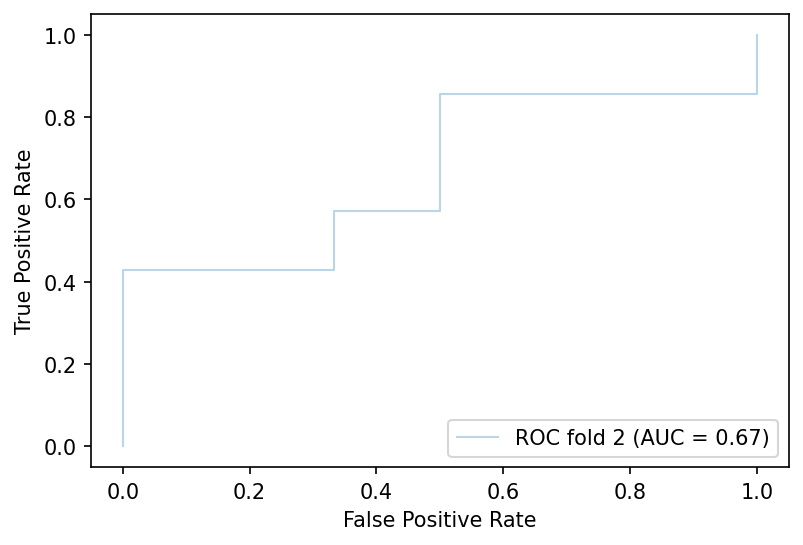

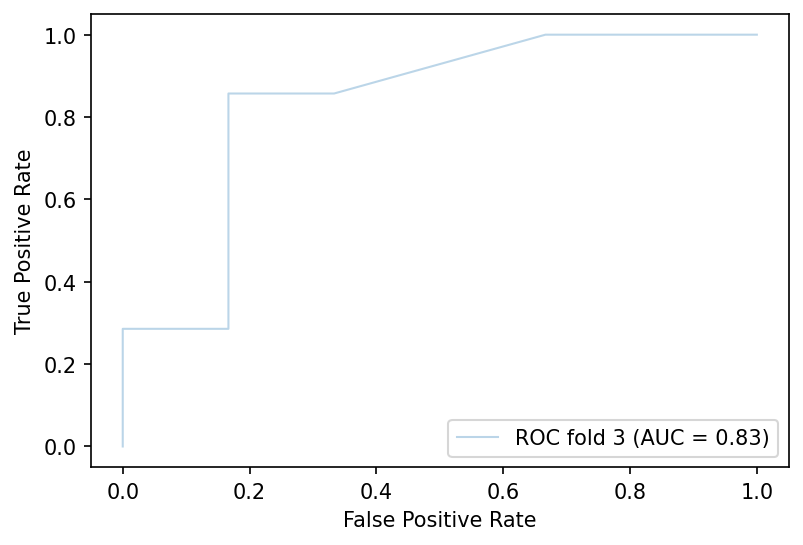

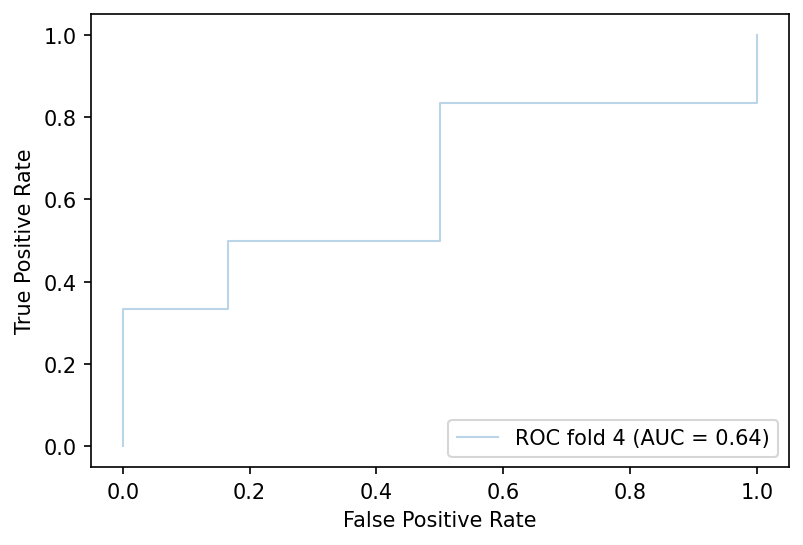

In [83]:
basil_model, basil_auc = xgboost_model(xbasil_train,ybasil_train,n_splits=5)

In [84]:
basil_auc

0.6849206349206349